In [1]:
# Load Air passengers data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
airDf = pd.read_csv('AirPassengers.csv',parse_dates=True,header =0)
airDf['Month'] = pd.to_datetime(airDf['Month'])
airDf.set_index('Month', inplace=True)
print("Air passengers : \n\n",airDf.head())

# Load daily minimum temperature data
tempDf = pd.read_csv('daily-minimum-temperatures-in-me.csv',header = 0,parse_dates=True,)
tempDf['Date'] = pd.to_datetime(tempDf['Date'])
tempDf.set_index('Date', inplace=True)
print("\n\nDaily minimum temperatures: \n\n",tempDf.head())

Air passengers : 

             #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


Daily minimum temperatures: 

             Temperatures
Date                    
1981-01-01          20.7
1981-01-02          17.9
1981-01-03          18.8
1981-01-04          14.6
1981-01-05          15.8


In [2]:
def stationaryCheck(dfRecv,x,y):
    #Original series
    df = dfRecv.copy(deep = True)
    plt.plot(df,label = 'Original data')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title("Stationarity Test")
    df['rollingMean'] = df[y].rolling(window = 12).mean()
    df['rollingStd'] = df[y].rolling(window = 12).std()
    plt.plot(df['rollingMean'],label = 'Rolling Mean')
    plt.plot(df['rollingStd'],label = 'Rolling Std')
    plt.legend()
    plt.show()

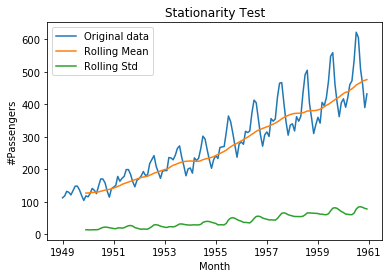

In [3]:
stationaryCheck(airDf,"Month","#Passengers")

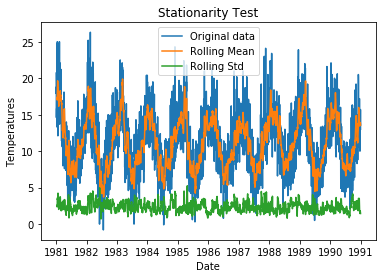

In [4]:
stationaryCheck(tempDf,"Date","Temperatures")

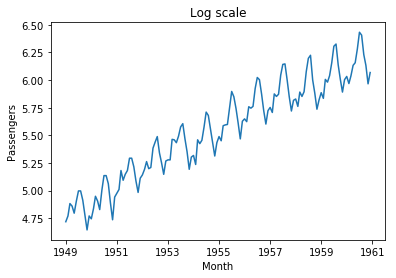

In [5]:
#Making the series stationary
airDf = np.log(airDf)
plt.plot(airDf)
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.title("Log scale")
plt.show()

/home/kritz/anaconda3/envs/scripts/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  


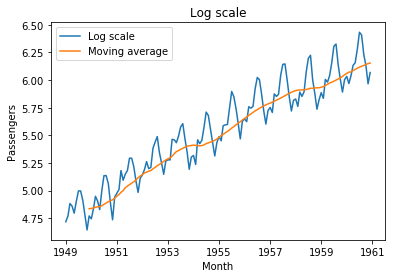

In [6]:
#Reducing the noise
ma = pd.rolling_mean(airDf,12)
plt.plot(airDf, label = "Log scale")
plt.plot(ma,label = "Moving average")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.title("Log scale")
plt.legend()
plt.show()

In [7]:
#Making it stationary
airDfNew = (airDf - ma)
airDfNew = airDfNew.dropna()

In [8]:
print(airDfNew.head(14))

            #Passengers
Month                  
1949-12-01    -0.065494
1950-01-01    -0.093449
1950-02-01    -0.007566
1950-03-01     0.099416
1950-04-01     0.052142
1950-05-01    -0.027529
1950-06-01     0.139881
1950-07-01     0.260184
1950-08-01     0.248635
1950-09-01     0.162937
1950-10-01    -0.018578
1950-11-01    -0.180379
1950-12-01     0.010818
1951-01-01     0.026593


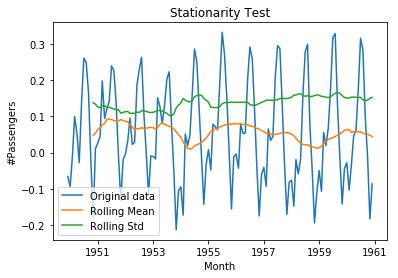

In [9]:
#Stationarity check
stationaryCheck(airDfNew,"Month","#Passengers")

/home/kritz/anaconda3/envs/scripts/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
  


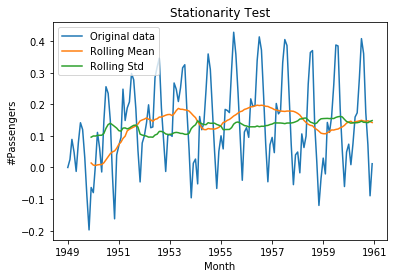

In [10]:
#Still not happy!
expA = pd.ewma(airDf,halflife = 12)
#Making it stationary
airDfNew = (airDf - expA)
airDfNew = airDfNew.dropna()
#Stationarity check
stationaryCheck(airDfNew,"Month","#Passengers")

/home/kritz/anaconda3/envs/scripts/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


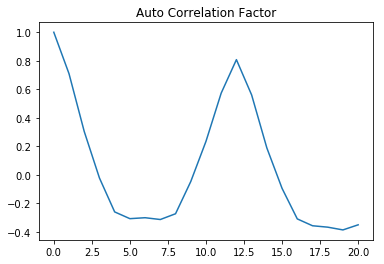

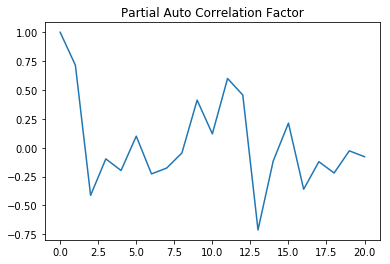

In [11]:
#ARIMA Model
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf,pacf

acf = acf(airDfNew,nlags=20)
pacf = pacf(airDfNew,nlags=20)

plt.plot(acf)
plt.title("Auto Correlation Factor")
plt.show()

plt.plot(pacf)
plt.title("Partial Auto Correlation Factor")
plt.show()

In [27]:
trainIndex = int(np.floor(0.7*airDfNew.shape[0]))
testIndex = int(np.ceil(0.7*airDfNew.shape[0]))
model = ARIMA(airDfNew[0:trainIndex], order = (2,1,1))
model.fit = model.fit(disp = 0)

In [33]:
forecast = model.fit.forecast(steps = 43)
forecastTrue = np.exp(forecast[0])

/home/kritz/anaconda3/envs/scripts/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


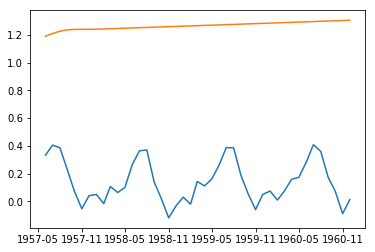

In [37]:
test = airDfNew[testIndex:]
test['forecast'] = forecastTrue
plt.plot(test['#Passengers'])
plt.plot(test['forecast'])
plt.show()

In [38]:
print(sum(test['forecast']-test['#Passengers'])**2)

2337.02115873


In [39]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(airDfNew[0:trainIndex], trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print (results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  100
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                 154.809
Date:                            Fri, 01 Jun 2018   AIC                           -303.619
Time:                                    12:53:25   BIC                           -295.803
Sample:                                01-01-1949   HQIC                          -300.456
                                     - 04-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0273      0.197     -0.139      0.890      -0.413       0.359
ma.S.L12      -0.6266      0.246   

In [40]:
forecast = results.forecast(steps = 43)
forecastTrue = np.exp(forecast[0])

/home/kritz/anaconda3/envs/scripts/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


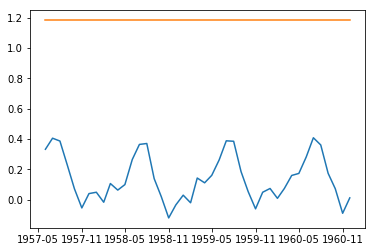

In [41]:
test = airDfNew[testIndex:]
test['forecast'] = forecastTrue
plt.plot(test['#Passengers'])
plt.plot(test['forecast'])
plt.show()

In [42]:
print(sum(test['forecast']-test['#Passengers'])**2)

2000.35834733


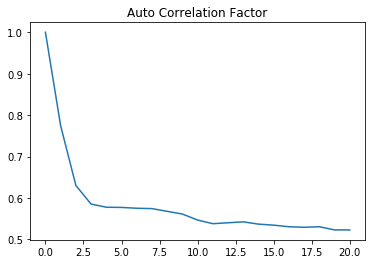

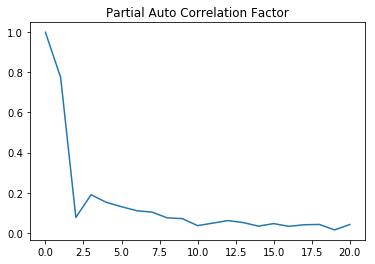

In [43]:
#ARIMA Model
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf,pacf

acf = acf(tempDf,nlags=20)
pacf = pacf(tempDf,nlags=20)

plt.plot(acf)
plt.title("Auto Correlation Factor")
plt.show()

plt.plot(pacf)
plt.title("Partial Auto Correlation Factor")
plt.show()

In [114]:
trainIndex = int(np.floor(0.7*tempDf.shape[0]))
testIndex = int(np.ceil(0.7*tempDf.shape[0]))
model = ARIMA(tempDf[0:trainIndex], order = (7,0,1))
model = model.fit(disp = 0)

In [115]:
forecast = model.forecast(steps = 1095)

/home/kritz/anaconda3/envs/scripts/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


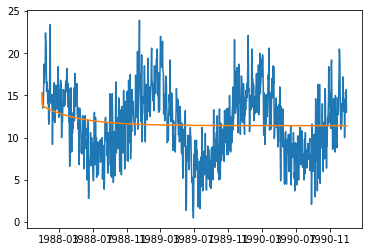

5600.63747469


In [116]:
test = tempDf[testIndex:]
test['forecast'] = forecast[0]
plt.plot(test['Temperatures'])
plt.plot(test['forecast'])
plt.show()

print(sum(test['forecast']-test['Temperatures'])**2)

In [111]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(tempDf[0:trainIndex], trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print (results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       Temperatures   No. Observations:                 2555
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -6249.117
Date:                            Fri, 01 Jun 2018   AIC                          12504.234
Time:                                    13:45:33   BIC                          12521.771
Sample:                                01-01-1981   HQIC                         12510.594
                                     - 12-31-1987                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0028      0.020      0.140      0.889      -0.037       0.043
ma.S.L12      -0.9996      0.122   